In [96]:
import torch_linear_regression as tlr

import torch
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt

import time

# Basic usage

In [97]:
## Generate data for regression
X, Y = sklearn.datasets.make_regression(
    n_samples=100,
    n_features=2,
    n_informative=10,
    bias=2,
    noise=50,
    random_state=42,
)

In [98]:
## Create model
model_ols = tlr.OLS()
## Fit model
model_ols.fit(X=X, y=Y)
## Predict
Y_pred = model_ols.predict(X)
## Score model
score = model_ols.score(X=X, y=Y)
print(f"R^2: {score}")

R^2: 0.7819072511229945


## Check the rank
The regression models use the closed form solutions for max performance, and if the input matrix is not full rank, the algorithm may fail. So, it is important to confirm that the input matrix is full rank before applying the regression models.

In [99]:
## Make a full rank matrix
X_full_rank = np.random.randn(100, 10)
## Check rank
print(f"X_full_rank is full rank: {tlr.check_full_rank(X_full_rank)}")
## Make model
model_ols_full_rank = tlr.OLS()
model_ols_full_rank.fit(X=X_full_rank, y=np.random.randn(100))

## Make a rank deficient matrix
X_rank_deficient = np.random.randn(100, 10)
X_rank_deficient[:, :3] = X_rank_deficient[:, :1]  ## Make matrix singular / not full rank / multicollinear
## Check rank
print(f"X_rank_deficient is full rank: {tlr.check_full_rank(X_rank_deficient)}")
## Make model
model_ols_rank_deficient = tlr.OLS()
try:
    model_ols_rank_deficient.fit(X=X_rank_deficient, y=np.random.randn(100))
except Exception as e:
    print(f"Error fitting model: {e}")

X_full_rank is full rank: True
X_rank_deficient is full rank: False
Error fitting model: Singular matrix


## Prefitting

In [100]:
## Create model
model_ols_pf = tlr.OLS(prefit_X=X)
## Fit model
model_ols_pf.fit(X=X, y=Y)  ## You should still pass X again even though it is prefit
## Predict
Y_pred = model_ols_pf.predict(X)
## Check that coefficients are the same
if np.allclose(model_ols.coef_, model_ols_pf.coef_):
    print("All good, prefit model coefficients are the same as the model coefficients!")
else:
    print("Uh oh, prefit model coefficients are different from the model coefficients")

All good, prefit model coefficients are the same as the model coefficients!


Prefitting is useful when you want to fit some `X` data to many different `y` data. By passing the `X` matrix into the `prefit` argument in the initialization you can avoid recomputing the same thing over and over again.

In [101]:
## Run a speed test

## Generate data for regression
X, Y = sklearn.datasets.make_regression(
    n_samples=1000,
    n_features=200,
    n_informative=100,
    n_targets=100,
    bias=2,
    noise=50,
    random_state=42,
)

## Fit without prefit
tic_multi = time.time()
model_ols_multi = tlr.OLS()
for y_i in Y.T:
    model_ols_multi.fit(X=X, y=y_i)
toc_multi = time.time()

## Fit with prefit
tic_multi_pf = time.time()
model_ols_multi_pf = tlr.OLS(prefit_X=X)
for y_i in Y.T:
    model_ols_multi_pf.fit(X=X, y=y_i)
toc_multi_pf = time.time()

## Check times
print(f"Time taken without prefit: {toc_multi - tic_multi}")
print(f"Time taken with prefit: {toc_multi_pf - tic_multi_pf}")

Time taken without prefit: 2.7744548320770264
Time taken with prefit: 0.023719072341918945


## Use numpy or torch arrays as inputs

In [102]:
## Make numpy and torch models
model_ols_np = tlr.OLS()
model_ols_np.fit(X=np.array(X), y=np.array(Y))

model_ols_torch = tlr.OLS()
model_ols_torch.fit(X=torch.as_tensor(X), y=torch.as_tensor(Y))

## Check that coefficients are the same
if np.allclose(model_ols_np.coef_, model_ols_torch.coef_.numpy()):
    print("All good, numpy model coefficients are the same as the torch model coefficients!")
else:
    print("Uh oh, numpy model coefficients are different from the torch model coefficients")

All good, numpy model coefficients are the same as the torch model coefficients!


## Run on a GPU

In [103]:
## Get device
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")  ## For Macs with Mn chips
else:
    DEVICE = torch.device("cpu")
print(f"Device: {DEVICE}")

X, Y = sklearn.datasets.make_regression(
    n_samples=1000000,
    n_features=10,
    n_informative=100,
    n_targets=100,
    bias=2,
    noise=50,
    random_state=42,
)

Device: cuda


In [161]:

## Create model on CPU
X = torch.as_tensor(X, device='cpu')
Y = torch.as_tensor(Y, device='cpu')
tic_cpu = time.time()
model_ols_cpu = tlr.OLS()
model_ols_cpu.fit(X=X, y=Y)
toc_cpu = time.time()

## Create model on GPU
X = X.to(DEVICE)
Y = Y.to(DEVICE)
tic_gpu = time.time()
model_ols_gpu = tlr.OLS()
model_ols_gpu.fit(X=X, y=Y)
toc_gpu = time.time()

## Check that coefficients are on the same device
print(f"Model coefficients device: {model_ols_gpu.coef_.device}")

## Check times
print(f"Time taken on CPU: {toc_cpu - tic_cpu}")
print(f"Time taken on GPU: {toc_gpu - tic_gpu}")

Model coefficients device: cuda:0
Time taken on CPU: 0.05090975761413574
Time taken on GPU: 0.005861759185791016


## Sklearn and PyTorch compatibility
The models are subclassed from `sklearn.base.BaseEstimator` and `torch.nn.Module` so they can be used in both frameworks.

##### From sklearn's `BaseEstimator`:

Methods:
- `fit`
- `predict`
- `fit_predict`
- `score`
  
Attributes:
- `coef_`
- `intercept_`

##### From PyTorch's `torch.nn.Module`:
- `forward`

Since the model is just matrix multiplication, addition, and possibly an SVD, you can treat the models' `fit` and `predict` methods as layers in a network and use them in a PyTorch pipeline.

In [163]:
## Generate data for regression
X, Y = sklearn.datasets.make_regression(
    n_samples=100,
    n_features=60,
    n_informative=5,
    n_targets=1,
    bias=2,
    noise=50,
    random_state=42,
)

## Make a new model
model_ols_2 = tlr.OLS()
model_ols_2.fit(X=X, y=Y)

## Predict using the `forward` method
## All three methods call .predict() and should give the same exact result
Y_pred_predict = model_ols_2.predict(X)
Y_pred_forward = model_ols_2.forward(X)
Y_pred_call = model_ols_2(X)

assert np.allclose(Y_pred_predict, Y_pred_call)
assert np.allclose(Y_pred_predict, Y_pred_forward)

In [176]:
## Let's use backpropagation to do hyperparameter tuning: fit the alpha parameter in a Ridge regression model
def get_XY():
    X, Y = sklearn.datasets.make_regression(
        n_samples=100,
        n_features=60,
        n_informative=5,
        n_targets=1,
        bias=2,
        noise=50,
        random_state=42,
    )
    X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X, Y, test_size=0.3, random_state=42)
    return (torch.as_tensor(var, dtype=torch.float32) for var in [X_train, Y_train, X_test, Y_test])

## Sweep through alpha values
scores_sweep = {}
for alpha in np.geomspace(1e-5, 1e10, num=300):
    X_train, Y_train, X_test, Y_test = get_XY()
    model_ridge_sweep = tlr.Ridge(alpha=alpha)
    model_ridge_sweep.fit(X_train, Y_train)
    score = model_ridge_sweep.score(X_test, Y_test)
    scores_sweep[alpha] = score

## Use backpropagation to fit the alpha parameter
fn_loss = torch.nn.MSELoss()
alpha_optimized = torch.nn.Parameter(torch.tensor(1.0))
optimizer = torch.optim.AdamW(params=[alpha_optimized], lr=0.3)
losses = []
for i in range(50):
    X_train, Y_train, X_test, Y_test = get_XY()
    model_ridge_optimized = tlr.Ridge(alpha=alpha_optimized)
    model_ridge_optimized.fit(X_train, Y_train)
    Y_pred = model_ridge_optimized.predict(X_test)
    loss = fn_loss(Y_pred, Y_test)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
score_optimized = model_ridge_optimized.score(X_test, Y_test).item()

Text(0, 0.5, 'Loss')

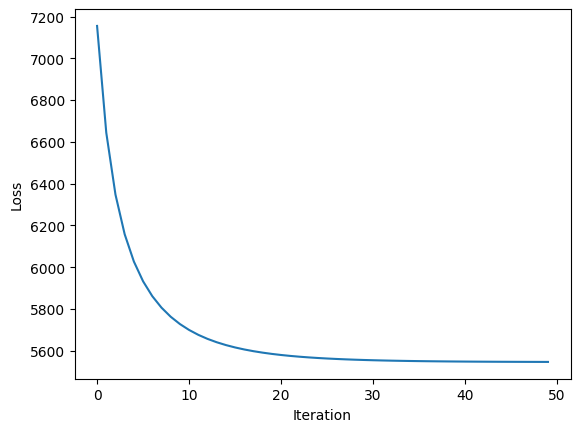

In [177]:
plt.figure()
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")

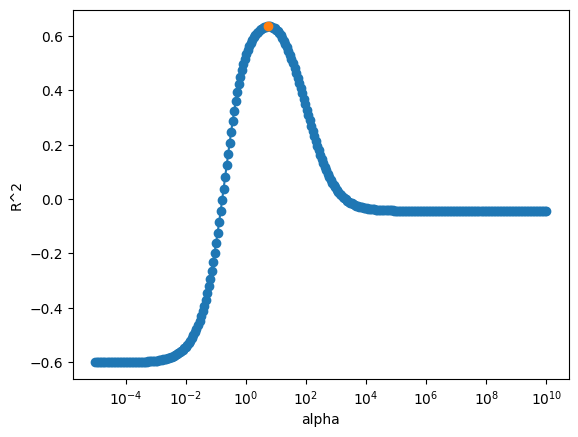

In [175]:
plt.figure()
plt.plot(list(scores_sweep.keys()), list(scores_sweep.values()), marker='o')
plt.plot(alpha_optimized.item(), score_optimized, marker='o')
plt.xlabel('alpha')
plt.ylabel('R^2')
plt.xscale('log')

## Available models:

In [12]:
tlr.OLS(
    fit_intercept=True,
    prefit_X=None,
)
tlr.Ridge(
    alpha=1e4,
    fit_intercept=True,
    prefit_X=None,
)
tlr.ReducedRankRidgeRegression(
    rank=5,
    alpha=1e4,
    fit_intercept=True,
    prefit_X=None,
)

ReducedRankRidgeRegression(alpha=10000.0, prefit_X=False, rank=5)

enjoy